In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2023-12-25 23:07:19.889955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-25 23:07:22.054074: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

2023-12-25 23:07:25.300276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 23:07:25.421920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 23:07:25.422413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Dataset Loading

In [3]:
img = glob.glob('./images/train/*/*.png')
label = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelIds.png') for path in img]

In [4]:
index = np.random.permutation(len(img))
img = np.array(img)[index]
label = np.array(label)[index]

In [5]:
len(img), len(label)

(2975, 2975)

In [6]:
img_val = glob.glob('./images/val/*/*.png')
label_val = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelIds.png') for path in img_val]

In [7]:
train_count = len(label)
val_count = len(label_val)

print(train_count, val_count)

2975 500


In [8]:
img_val[10:15]

['./images/val/munster/munster_000033_000019_leftImg8bit.png',
 './images/val/munster/munster_000071_000019_leftImg8bit.png',
 './images/val/munster/munster_000124_000019_leftImg8bit.png',
 './images/val/munster/munster_000034_000019_leftImg8bit.png',
 './images/val/munster/munster_000062_000019_leftImg8bit.png']

In [9]:
label_val[10:15]

['./gtFine/val/munster/munster_000033_000019_gtFine_labelIds.png',
 './gtFine/val/munster/munster_000071_000019_gtFine_labelIds.png',
 './gtFine/val/munster/munster_000124_000019_gtFine_labelIds.png',
 './gtFine/val/munster/munster_000034_000019_gtFine_labelIds.png',
 './gtFine/val/munster/munster_000062_000019_gtFine_labelIds.png']

In [10]:
dataset_train = tf.data.Dataset.from_tensor_slices((img, label))
dataset_val = tf.data.Dataset.from_tensor_slices((img_val, label_val))

2023-12-25 23:07:25.533023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 23:07:25.533305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-25 23:07:25.533463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
from PIL import Image
import numpy as np
import os


# 获取所有标注图像的路径
annotation_paths = label

# Cityscapes类别数 - 可能需要根据实际情况调整
num_classes = 34

# 初始化总计数器
total_pixel_counts = [0] * num_classes

# 遍历所有图像并统计像素
for annotation_path in annotation_paths:
    annotation = Image.open(annotation_path)
    annotation = np.array(annotation)

    for i in range(num_classes):
        total_pixel_counts[i] += np.sum(annotation == i)

# 打印结果
for i, count in enumerate(total_pixel_counts):
    print(f"Class {i} has {count} total pixels")


# Image Augumentation

In [11]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

img_1 = read_png(img[0])
label_1 = read_png_label(label[0])

img_1.shape

label_1.shape

TensorShape([1024, 2048, 1])

In [12]:
concat_img = tf.concat([img_1, label_1], axis=-1)

In [13]:
concat_img.shape

TensorShape([1024, 2048, 4])

In [14]:
def crop_img(img, mask):
    concat_img = tf.concat([img, mask], axis=-1)
    concat_img = tf.image.resize(concat_img, (280, 280),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [256, 256, 4])
    return crop_img[ :, :, :3], crop_img[ :, :, 3:]

In [15]:
img_1, label_1 = crop_img(img_1, label_1)

In [16]:
label_1.shape

TensorShape([256, 256, 1])

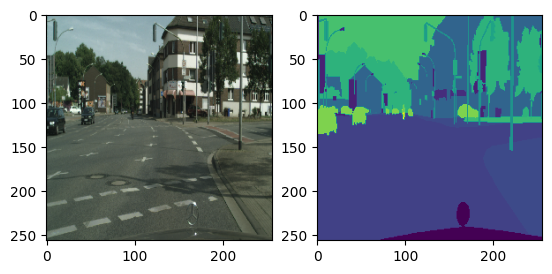

In [17]:
plt.subplot(1,2,1)
plt.imshow(img_1.numpy())
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label_1.numpy()))

In [18]:
def normal(img, mask):
    img = tf.cast(img, tf.float32)/127.5 -1
    mask = tf.cast(mask, tf.int32)
    return img, mask

def load_image_train(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    img, mask = crop_img(img, mask)
    if tf.random.uniform(())>0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    img, mask = normal(img, mask)    
    return img, mask

def load_image_val(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    img = tf.image.resize(img, (256, 256))
    mask = tf.image.resize(mask, (256, 256))
    img, mask = normal(img, mask)
    return img, mask

BCTCH_SIZE = 32
BUFFER_SIZE = 300
step_per_epoch = train_count//BCTCH_SIZE
val_step = val_count//BCTCH_SIZE

In [19]:
auto = tf.data.experimental.AUTOTUNE

dataset_train = dataset_train.map(load_image_train, num_parallel_calls=auto)
dataset_val = dataset_val.map(load_image_val, num_parallel_calls=auto)

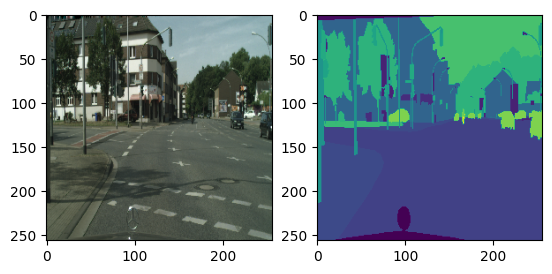

In [20]:
for i, m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy() + 1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

In [21]:
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)
dataset_val = dataset_val.batch(BCTCH_SIZE)

dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))>

# 定义linknet模型

In [22]:
import tensorflow as tf
from tensorflow import keras

def ConvBlock(x, units, k_size=3, stride=1, use_bias=False):
    x = keras.layers.Conv2D(units, kernel_size=k_size, strides=stride, padding='same', use_bias=use_bias)(x)
    x = keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    return x

def EncodeBlock(x, units):
    shortcut = ConvBlock(x, units, stride=2)

    x = ConvBlock(x, units, stride=2)
    x = ConvBlock(x, units, stride=1)

    x = x + shortcut

    x = ConvBlock(x, units, stride=1)
    x = ConvBlock(x, units, stride=1)
    return x + x

def DecodeBlock(x, units1, units2):
    x = ConvBlock(x, units1, k_size=1)
    x = DeconvBlock(x, units1)
    x = ConvBlock(x, units2, k_size=1)
    return x

def DeconvBlock(x, units, k_size=3, stride=2, padding='same'):
    x = keras.layers.Conv2DTranspose(units, kernel_size=k_size, strides=stride, padding=padding, activation='softmax')(x)
    return x

def Net(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = ConvBlock(inputs, 64, k_size=3, stride=2)
    x = keras.layers.MaxPooling2D(padding='same')(x)

    e1 = EncodeBlock(x, 64)
    e2 = EncodeBlock(e1, 128)
    e3 = EncodeBlock(e2, 256)
    e4 = EncodeBlock(e3, 512)

    d4 = DecodeBlock(e4, 512, 256) + e3
    d3 = DecodeBlock(d4, 256, 128) + e2
    d2 = DecodeBlock(d3, 128, 64) + e1
    d1 = DecodeBlock(d2, 64, 64)

    f1 = DeconvBlock(d1, 64)
    f2 = ConvBlock(f1, 64)
    f3 = DeconvBlock(f2, 34, k_size=3)

    model = keras.Model(inputs=inputs, outputs=f3)
    return model


In [23]:
input_shape = (256, 256, 3) 
model = Net(input_shape)

# model.summary()

In [24]:
class ConfidenceAwareLoss(tf.keras.losses.Loss):
    def __init__(self, confidence_penalty=0.1, label_smoothing=0.1, 
                 name="confidence_aware_loss", 
                 reduction=tf.keras.losses.Reduction.AUTO):
        super(ConfidenceAwareLoss, self).__init__(name=name, reduction=reduction)
        self.confidence_penalty = confidence_penalty
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        # 基础损失使用 sparse_categorical_crossentropy
        basic_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

        # 应用标签平滑
        num_classes = tf.shape(y_pred)[-1]
        y_true_smoothed = tf.one_hot(tf.squeeze(tf.cast(y_true, tf.int32)), depth=num_classes)
        y_true_smoothed = y_true_smoothed * (1 - self.label_smoothing) + (self.label_smoothing / num_classes)

        # 计算置信度
        confidence = tf.reduce_max(tf.nn.softmax(y_pred, axis=-1), axis=-1)

        # 置信度惩罚
        correct_predictions = tf.equal(tf.argmax(y_true_smoothed, axis=-1), tf.argmax(y_pred, axis=-1))
        confidence_penalty = tf.where(correct_predictions, 0., self.confidence_penalty * confidence)

        # 总损失
        total_loss = basic_loss + confidence_penalty
        return tf.reduce_mean(total_loss)




In [25]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(dataset_train, validation_data=dataset_val, epochs=100)


Epoch 1/100


2023-12-25 23:07:43.272930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-25 23:07:50.121079: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3a82c34520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-25 23:07:50.121121: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-25 23:07:50.270038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-25 23:07:50.888445: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 [==============================] - 77s 501ms/step - loss: 1.8597 - accuracy: 0.5191 - val_loss: 3.0700 - val_accuracy: 0.3286
Epoch 2/100
93/93 [==============================] - 43s 416ms/step - loss: 1.0680 - accuracy: 0.7115 - val_loss: 2.9514 - val_accuracy: 0.3286
Epoch 3/100
93/93 [==============================] - 42s 415ms/step - loss: 0.8472 - accuracy: 0.7756 - val_loss: 2.7532 - val_accuracy: 0.3244
Epoch 4/100
93/93 [==============================] - 43s 417ms/step - loss: 0.7692 - accuracy: 0.7935 - val_loss: 2.3450 - val_accuracy: 0.3977
Epoch 5/100
93/93 [==============================] - 43s 416ms/step - loss: 0.7318 - accuracy: 0.8023 - val_loss: 1.7421 - val_accuracy: 0.5521
Epoch 6/100
93/93 [==============================] - 42s 415ms/step - loss: 0.6975 - accuracy: 0.8103 - val_loss: 1.1078 - val_accuracy: 0.7142
Epoch 7/100
93/93 [==============================] - 43s 417ms/step - loss: 0.6663 - accuracy: 0.8180 - val_loss: 0.9159 - val_accuracy: 0.7546
Epoc

1/1 [==============================] - 0s 459ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


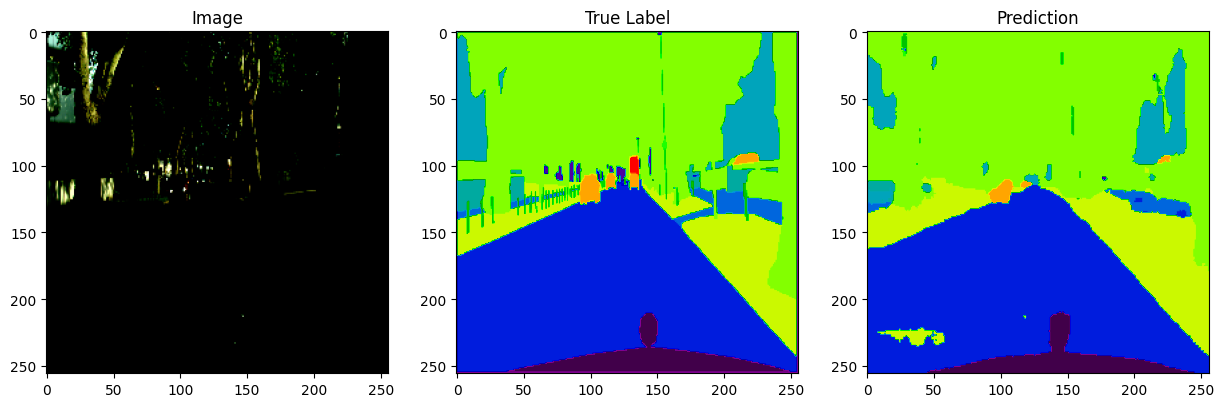

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


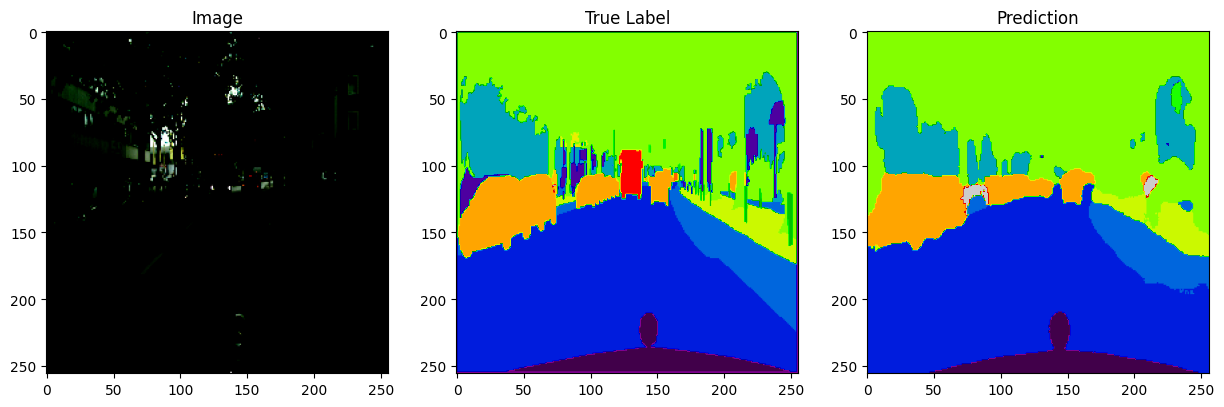

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


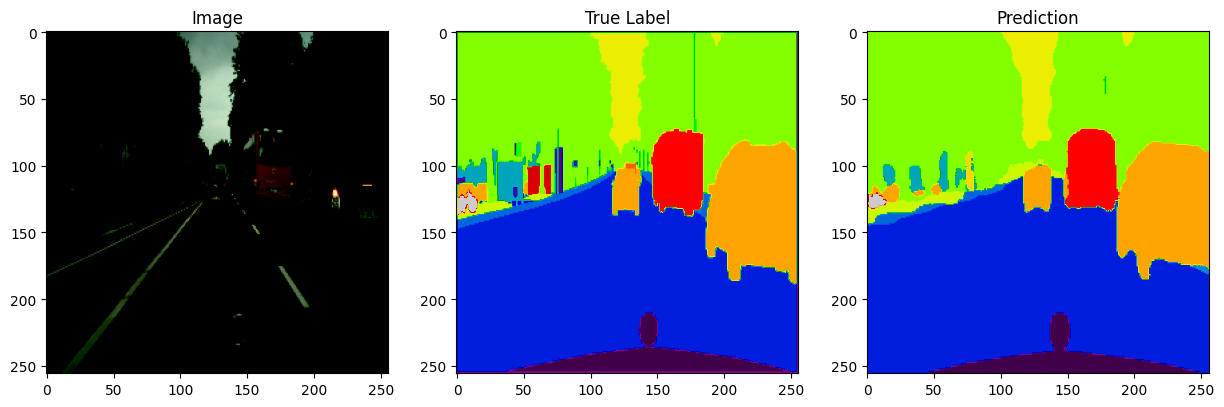

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_predictions(model, dataset, num_classes=34, num_samples=3):
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)

        for i in range(num_samples):
            image = images[i].numpy()
            label = labels[i].numpy().squeeze()  # 假设标签是单通道的
            prediction = predictions[i].numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.title("Image")
            plt.imshow(image)

            plt.subplot(1, 3, 2)
            plt.title("True Label")
            plt.imshow(label, cmap='nipy_spectral', vmin=0, vmax=num_classes-1)

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(prediction, cmap='nipy_spectral', vmin=0, vmax=num_classes-1)

            plt.show()

plot_predictions(model, dataset_val, num_classes=34, num_samples=3)


/tmp/ipykernel_1706/1592835264.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', num_classes)


1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


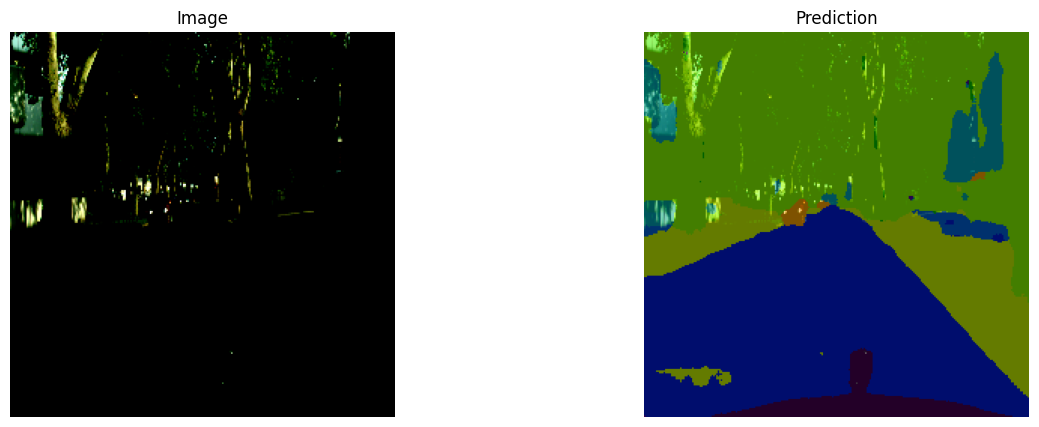

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


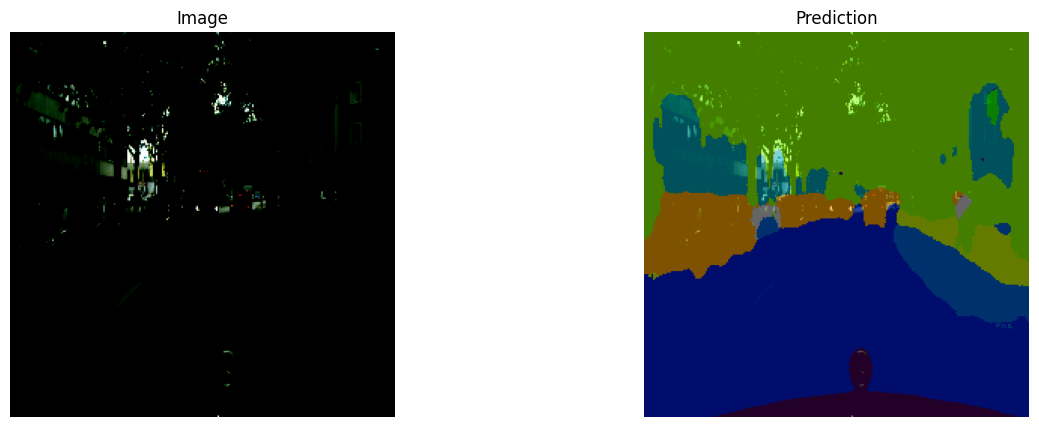

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


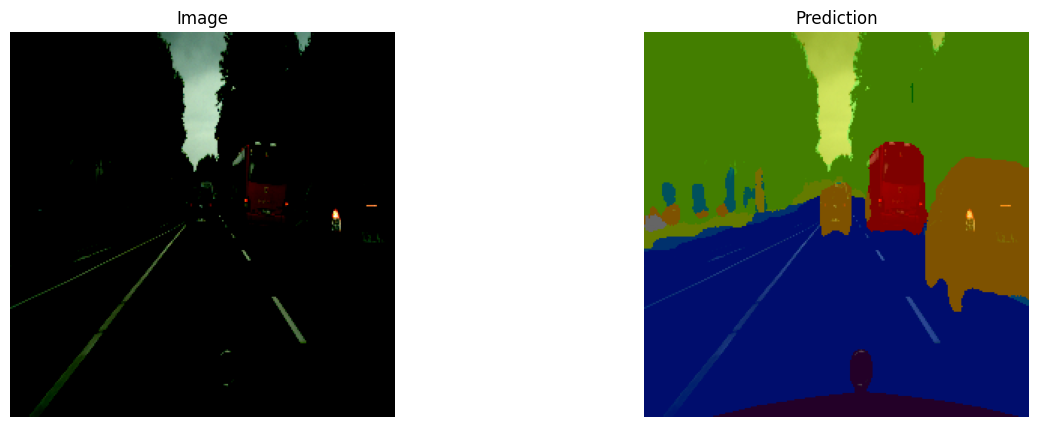

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_predictions(model, dataset, num_classes=34, num_samples=3):
    # 创建一个颜色映射
    colors = plt.cm.get_cmap('nipy_spectral', num_classes)
    
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)

        for i in range(num_samples):
            image = images[i].numpy()
            label = labels[i].numpy().squeeze()  # 假设标签是单通道的
            prediction = predictions[i].numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.title("Image")
            plt.imshow(image)
            plt.axis('off')

            # plt.subplot(1, 3, 2)
            # plt.title("True Label")
            # true_label_mask = colors(label)
            # plt.imshow(image)
            # plt.imshow(true_label_mask, cmap='nipy_spectral', vmin=0, vmax=num_classes-1, alpha=0.5)
            # plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Prediction")
            prediction_mask = colors(prediction)
            plt.imshow(image)
            plt.imshow(prediction_mask, cmap='nipy_spectral', vmin=0, vmax=num_classes-1, alpha=0.5)
            plt.axis('off')

            plt.show()

plot_predictions(model, dataset_val, num_classes=34, num_samples=3)
